In [1]:
# Adding to python modules path the parent directory, in which is defined a lib's module, with all methods utilized
import sys
sys.path.append("..")

# Autoreload lib every time
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
from matplotlib import pyplot as plt

import numpy as np
import imageio

Las funciones importadas de lib, fueron desarrolladas para llevar a cabo la práctica. Las mismas fueron implementadas en el módulo **lib**, para que su implementación sea más clara y legible.

El código fuente del módulo se encuentra en: https://github.com/andres-rad/Vision-Computadora/tree/master/lib

In [3]:
from lib.ruidos import add_gaussian_noise, mult_rayleigh_noise
from lib.edge_detectors import laplacianEdgeDetector, LLV, LOG

In [4]:
# Notebook-wide matplotlib configs
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['figure.figsize'] = (15,10)

In [5]:
def showAllImages(images, extraFormatAxis = None, figSize=None):
    """Show all images in a numpy array. Also, apply extra format to each axis.""" 
    def doFormatAxis(anAxis):
        anAxis.xaxis.set_visible(False)
        anAxis.yaxis.set_visible(False)
        if extraFormatAxis != None:
            extraFormatAxis(anAxis)
        
    if figSize is None:
        figSize = (15,10)
        
    shape = images.shape
    rows = shape[0]
    cols = shape[1]
    fig, axis = plt.subplots(nrows=rows, ncols=cols, figsize=figSize)
    for r in range(rows):
        for c in range(cols):
            if cols != 1 and rows != 1:                
                axis[r][c].imshow(images[r,c])
                doFormatAxis(axis[r][c])
            elif cols == 1 and rows == 1:
                axis.imshow(images[r,c])
                doFormatAxis(axis)
            else:
                index = max(r,c)
                axis[index].imshow(images[r,c])
                doFormatAxis(axis[index])

    plt.show()

# Práctica 4: Detección de bordes y esquinas

### Ejercicio 1
Contaminar las imágenes Lena y test con ruido gaussiano aditivo para distintos valores de σ y con ruido Rayleigh multiplicativo para algún ξ > 0.

In [6]:
lenaImage = imageio.imread('../img/Images_test/lena.png')
testImage = imageio.imread('../img/Images_test/test.png')

mean = 0
std = 10
epsilon = 1
xi = .1

def doApplyGuassianNoise(anImage):
    return add_gaussian_noise(anImage, mean, std)
    
def doApplyRaileighNoise(anImage):
    return mult_rayleigh_noise(anImage, xi)

lenasWithNoises = [lenaImage, doApplyGuassianNoise(lenaImage), doApplyRaileighNoise(lenaImage)]
testWithNoises = [testImage, doApplyGuassianNoise(testImage), doApplyRaileighNoise(testImage)]

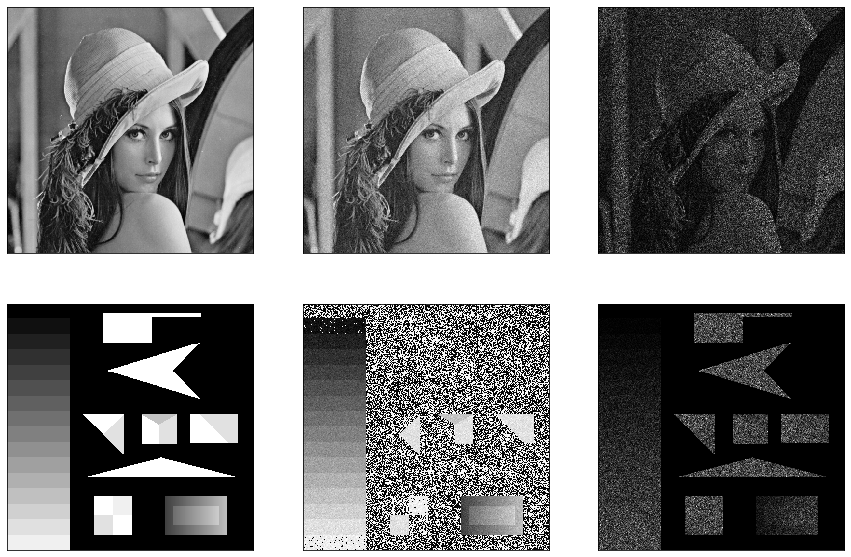

In [7]:
showAllImages(np.array([lenasWithNoises,\
                        testWithNoises]))

Resulta interesante notar cómo en una imágen con los valores de grises distribuidos de manera más uniforme (en el caso de lena por ejemplo), el ruido gaussiano afecta de una manera menos drástica. En cambio, en una imágen cuyos colores más habituales son los dos extremos, sean blanco y negro, un ruido gaussiano de con un valor $\sigma = 10$, destruye totalmente la misma.

Por otro lado, el ruido de Rayleigh afecta de igual manera a ambas imágenes.

### Ejercicio 2
Implementar los siguientes detectores de borde y aplicarlos a las versiones contaminadas en el item 1.
1. Método del Laplaciano
2. Método del Laplaciano con evaluación local de varianza
3. Método del Laplaciano del Gaussiano *(Marr - Hildreth)*

#### Método del Laplaciano

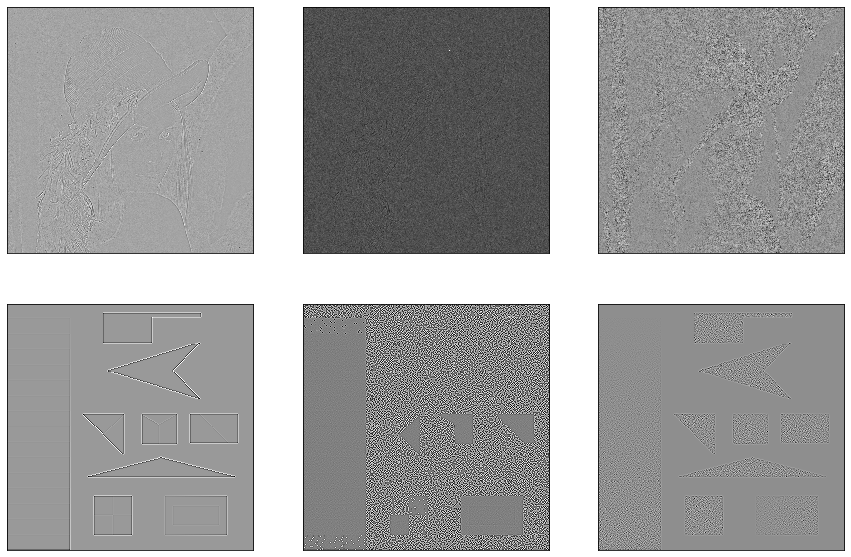

In [8]:
showAllImages(np.array([[laplacianEdgeDetector(aLena) for aLena in lenasWithNoises], \
                        [laplacianEdgeDetector(aTest) for aTest in testWithNoises]]))

#### Método del Laplaciano con evaluación local de varianza

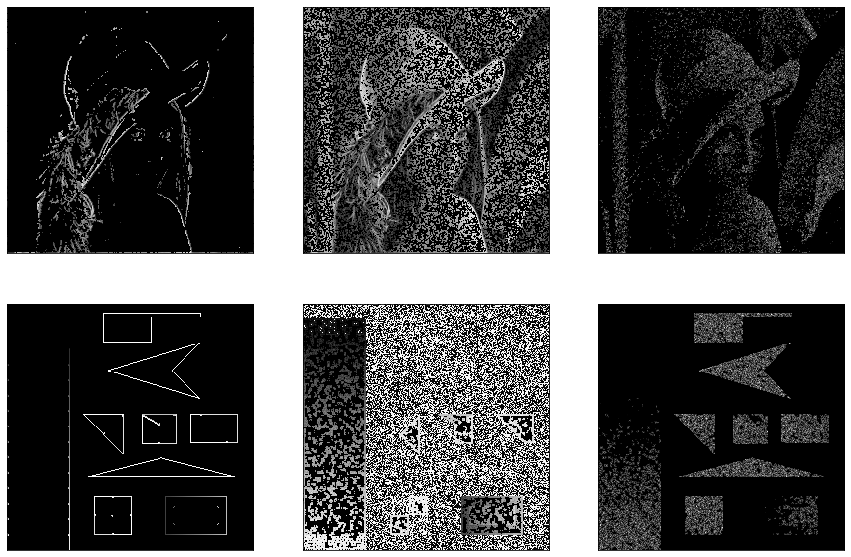

In [9]:
edgeDetectorToApply = lambda image: LLV(image, 90)
showAllImages(np.array([[edgeDetectorToApply(aLena) for aLena in lenasWithNoises], \
                        [edgeDetectorToApply(aTest) for aTest in testWithNoises]]))

#### Método del Laplaciano del Gaussiano *(Marr - Hildreth)*

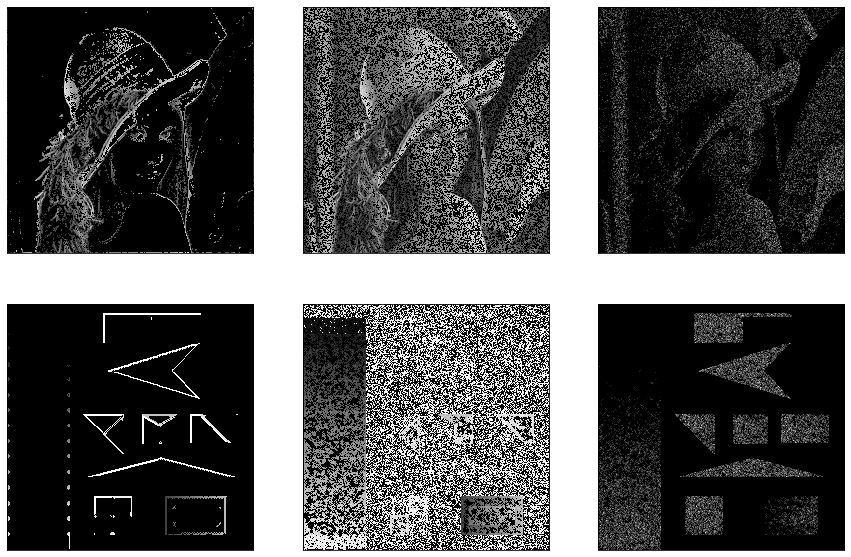

In [10]:
edgeDetectorToApply = lambda image: LOG(image, 1)
showAllImages(np.array([[edgeDetectorToApply(aLena) for aLena in lenasWithNoises], \
                        [edgeDetectorToApply(aTest) for aTest in testWithNoises]]))

### Ejercicio 3
Implementar el método de Canny. Aplicarlo a imágenes y sus versiones contaminadas con diferentes niveles de ruido Gaussiano, Rayleigh, Exponencial y Sal & Pimienta, usando operadores de gradiente de Roberts, Sobel y Prewitt. 

Se debe incluir:

1. La implementación del método de supresión de no máximos para eliminar múltiples respuestas de borde. Aplicarlo a dos imágenes y a sus versiones contaminadas con ruido.
2. La implementación el método de umbralización con histéresis para eliminar respuestas de borde falsas. Aplicarlo a dos imágenes y a sus versiones contaminadas.

In [11]:
from lib.canny import CannyEdgeDetector
from lib.edge_detectors import _gaussian_kern as generateGaussianKernel

hystheresisLowerThreshold = 40
hystheresisUpperThreshold = 70
gaussianDeviation = .5

gradientCalculators = ['Sobel', 'Prewitt', 'Roberts']

def applyCannyWithGradientCalculator(anImage, aGradientCalculatorName):
    return CannyEdgeDetector(lenaImage, gaussianBlurKernelDeviation=gaussianDeviation, gradient=aGradientCalculatorName,\
                                     lowerThreshold=hystheresisLowerThreshold, upperThreshold=hystheresisUpperThreshold)\
                                     .apply()

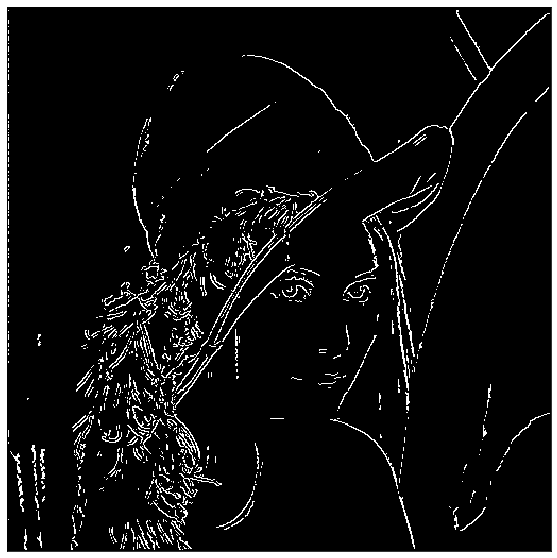

In [12]:
showAllImages(np.array([[applyCannyWithGradientCalculator(lenaImage, 'Sobel')]]))

Los valores de el umbral usado para la etapa de Canny de *Umbralización por histerésis* fueron hallados empíricamente, y son los que mejor resultado visual dan, calculando en gradiente mediante Sobel.

*Canny* aplicado a diferentes lenas: sin ruido, con ruido gaussiano, y con rudio de rayleigh. Usando como gradiente máscaras de Sobel.

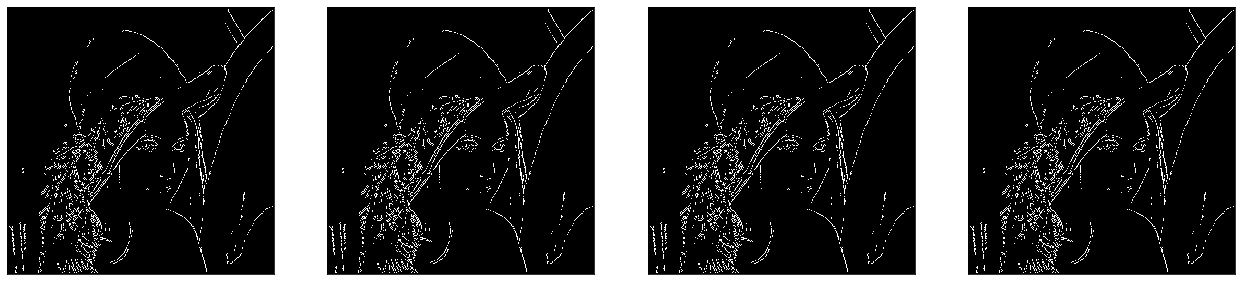

In [13]:
showAllImages(np.array([[
    applyCannyWithGradientCalculator(aLena, 'Sobel') for aLena in [lenaImage] + lenasWithNoises
]]), figSize=(22,15))

*Canny* aplicado a diferentes lenas: sin ruido, con ruido gaussiano, y con rudio de rayleigh. Usando como gradiente máscaras de Roberts.

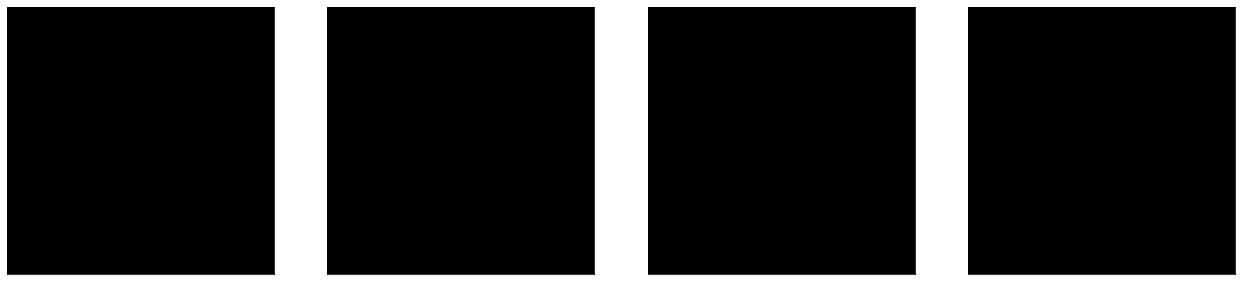

In [14]:
showAllImages(np.array([[
    applyCannyWithGradientCalculator(aLena, 'Roberts') for aLena in [lenaImage] + lenasWithNoises
]]), figSize=(22,15))

Es intersante notar como usando los mismos parámetros de umbrales que funcionaban bien para Sobel, no lo hacen para Roberts. Esto debe deberse a que al cambiar la dimensión del kernel mismo, y las direcciones mediantes las cuales calcula el gradiente, los valores obtenidos son muy diferentes.
A continuación, se realiza la misma aplicación de Canny, pero con el umbral ajustado para Roberts.

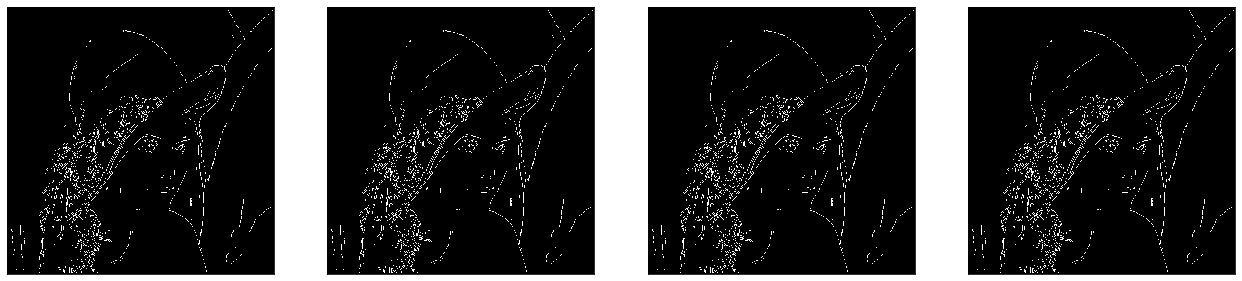

In [15]:
hystheresisLowerThreshold = 5
hystheresisUpperThreshold = 15
showAllImages(np.array([[
    applyCannyWithGradientCalculator(aLena, 'Roberts') for aLena in [lenaImage] + lenasWithNoises
]]), figSize=(22,15))
hystheresisLowerThreshold = 40
hystheresisUpperThreshold = 70

*Canny* aplicado a diferentes lenas: sin ruido, con ruido gaussiano, y con rudio de rayleigh. Usando como gradiente máscaras de Prewitt.

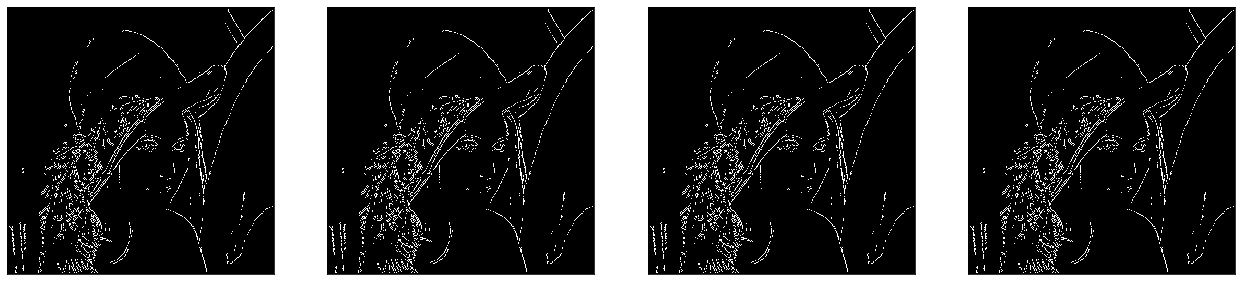

In [16]:
showAllImages(np.array([[
    applyCannyWithGradientCalculator(aLena, 'Prewitt') for aLena in [lenaImage] + lenasWithNoises
]]), figSize=(22,15))

### Ejercicio 4
Implementar los siguientes métodos de detección de esquinas:
1. Harris
2. Szeliski
3. Shi - Tomasi
4. Triggs

El detector de esquinas de Harris usa como base al de **Moravec** (en realidad Harris es una mejora de este), por lo que resultó interesante primero realizar una implementación del mismo.

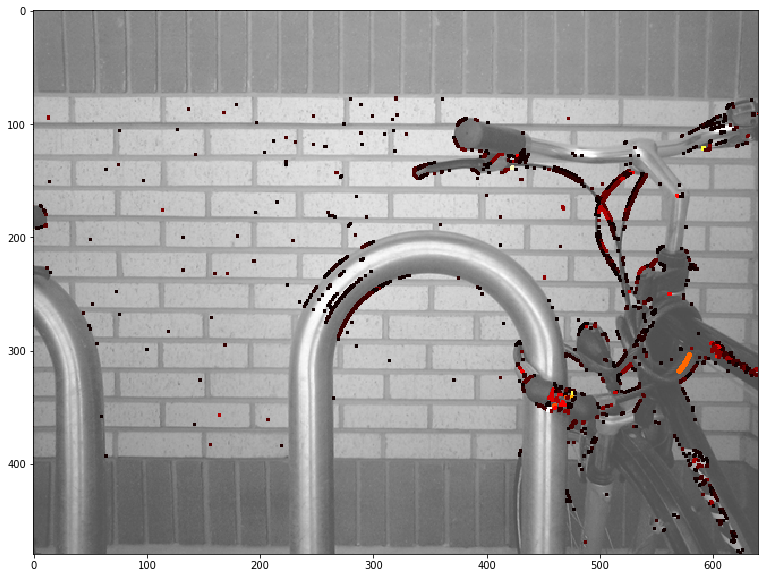

In [32]:
from lib.corners import moravecCornerDetection, convolvedMoravecCornerDetection

bikesImage = imageio.imread('../img/Images_test/Bikesgray.jpg')

cornernessThreshold = 700

cornernessMap = convolvedMoravecCornerDetection(bikesImage, threshold=cornernessThreshold, overdrawCorners=True)
cornernessMap = np.ma.masked_where(cornernessMap < cornernessThreshold, cornernessMap)

plt.imshow(bikesImage, alpha=.7)
plt.imshow(cornernessMap, cmap='hot', interpolation='none')

Detector de esquinas de Harris, tomando como métrica $R = det(A) - \alpha * traza(A)$. Falta aplicarle la etapda de *supersión de no máximos*. Como *threshold* se está utilizando el 65% de 

MAX = 138527294681.91534, MIN = 0.0


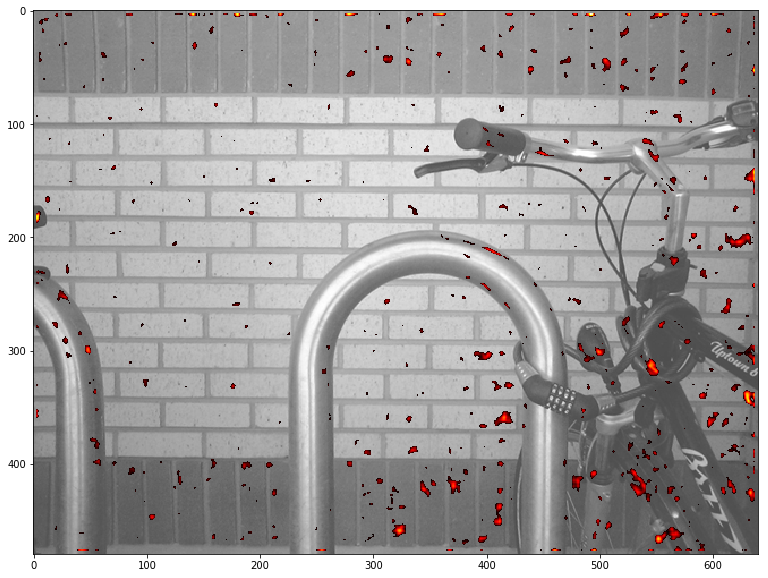

In [69]:
from lib.corners import harrisCornerDetector
from scipy.stats import describe

cornernessThreshold = 138527294681.91534*.65

cornernessMap = harrisCornerDetector(bikesImage, Rthreshold=cornernessThreshold, windowSize=7)

print(f'MAX = {np.max(cornernessMap)}, MIN = {np.min(cornernessMap)}')

cornernessMap = np.ma.masked_where(cornernessMap < cornernessThreshold, cornernessMap)

plt.imshow(bikesImage, alpha=.7)
plt.imshow(cornernessMap, cmap='hot', interpolation='none')